#### Date: 21-06-2022

#### Challenge: multiclass classification for <code>ChestMNIST</code> dataset (https://arxiv.org/abs/2110.14795)
#### Tutorial: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [18]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist as medm
from medmnist import INFO, Evaluator
import pandas as pd

In [22]:
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 256
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medm, info['python_class'])

In [29]:
DataClass

medmnist.dataset.ChestMNIST

In [36]:
n_classes

14

In [25]:
info

{'python_class': 'ChestMNIST',
 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/chestmnist.npz?download=1',
 'MD5': '02c8a6516a18b556561a56cbdd36c4a8',
 'task': 'multi-label, binary-class',
 'label': {'0': 'atelectasis',
  '1': 'cardiomegaly',
  '2': 'effusion',
  '3': 'infiltration',
  '4': 'mass',
  '5': 'nodule',
  '6': 'pneumonia',
  '7': 'pneumothorax',
  '8': 'consolidation',
  '9': 'edema',
  '10': 'emphysema',
  '11': 'fibrosis',
  '12': 'pleural',
  '13': 'hernia'},
 'n_channels': 1,
 'n_samples': {'train': 78468, 'val': 11219, 'test': 22433},
 'license': 'CC BY 4.0'}

In [24]:
task # we should choose 'multi-label'

'multi-label, binary-class'

In [27]:
# define a preprocessing func to normalize data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [28]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz


In [30]:
# explore the train and test dataset
print(train_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: /home/jiawei/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root location: /hom

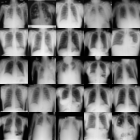

In [32]:
# visualization as per montage
train_dataset.montage(length=5)

#### Then, we define a baseline model for illustration using ResNet18 (28) NN arch, object function and optimizer that we use to classify.
#### Constructing ResNet18 from Scratch in Python https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch/notebook

In [40]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

    
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

resn18_model = ResNet18(n_channels, n_classes)

In [42]:
resn18_model

ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1

#### Perform traning and evaluation

In [48]:
# define the loss function and optimizer
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# Try to use
#optimizer_adam = optim.Adam(resn18_model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = optim.SGD(resn18_model.parameters(), lr=lr, momentum=0.9)

# train ChestMNIST Data for 3 epochs

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    resn18_model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = resn18_model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|█████████████████████████████████████████| 307/307 [37:40<00:00,  7.36s/it]


#### Save the model and predict

In [52]:
%%bash
mkdir -p manuel_git_repo/resnet18_chestmnist_test

In [56]:
# save states of the trained model
torch.save(resn18_model.state_dict(), "manuel_git_repo/resnet18_chestmnist_test/3epochs_model")

In [58]:
%%bash
wc -l manuel_git_repo/resnet18_chestmnist_test/3epochs_model

154534 manuel_git_repo/resnet18_chestmnist_test/3epochs_model


In [61]:
resn18_model()

TypeError: ResNet18.forward() missing 1 required positional argument: 'x'

In [ ]:
# predict the test dataset using the train model (3 epochs)
resn18_model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            outputs = outputs.softmax(dim=-1)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)

#### Write functions to evaluation the prediction above